In [4]:
import tkinter as tk
from tkinter import filedialog as fd
import os
import os.path 
import tkinter as tk
from PIL import Image
from skimage import transform, img_as_int, exposure
import skimage.io as io
import tkinter.messagebox as mb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage, spatial
from cmath import inf
import sys
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage import transform
import Polywarp
import numpy as np
import matplotlib.pyplot as plt
import skimage as si
import skimage.io as io
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import axes
from matplotlib import figure
from scipy.io import savemat

from numpy import exp, power
from skimage.restoration import rolling_ball


root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()




''

In [5]:
#Instead of calculating the bead mapping we can load the transformation generated with channel_map
tr_G2R = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the forward transform file", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
tr_G2R.params = np.load(file_path)
tr_R2G = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the inverse transform file", initialdir = os.path.dirname(file_path))
tr_R2G.params = np.load(file_path)

path = fd.askdirectory(title="Select the folder with smFRET stacks", initialdir="D:/Experiments/MUSCLE DONUTS")

# Main cycle

F:/221130_FC_Nano_CCR5_4N/Blind\Pos186.tiff
Starting blob detection


C:\Users\Anton\AppData\Local\Temp\ipykernel_20004\1690777970.py:45: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])


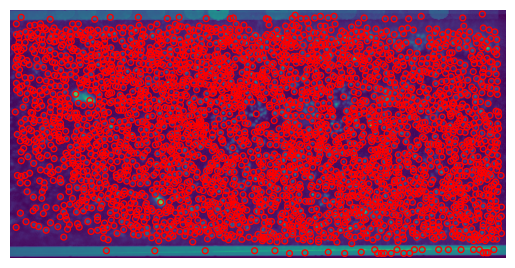

Working on frame 0
F:/221130_FC_Nano_CCR5_4N/Blind\Pos493.tiff
Starting blob detection


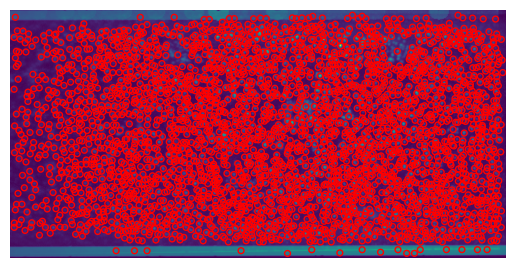

Working on frame 0
F:/221130_FC_Nano_CCR5_4N/Blind\Pos375.tiff
Starting blob detection


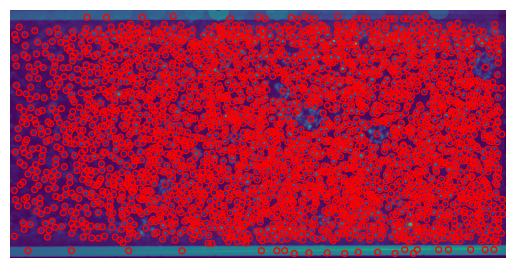

Working on frame 0


In [6]:
os.chdir(path)
r = 3 # Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
rb = 5 # Half-width of the background aperture for trace extraction 
# (bacground is calculated as a median of intensities in a rectangular aperture between r and rb)
# a = np.subtract(range(2*rb+1), rb)
at = [[j,i] for i in range(2*rb+1) for j in range(rb-r)]
bt = [[j,i] for i in range(2*rb+1) for j in range(r+rb+1,2*rb+1)]
ct = [[j,i] for i in range(rb-r) for j in range(rb-r,r+rb+1)]
dt = [[j,i] for i in range(r+rb+1,2*rb+1) for j in range(rb-r,r+rb+1)]
idx_bg = np.subtract(np.concatenate([at,bt,ct,dt]), [rb,rb]) # Indexes that define the background aperture
counter = 0 
for current_dir,dirs,files in os.walk(path) :
    for el in files: 
    #print(dirs)
        if el.split('.')[-1].lower() == 'tif' or el.split('.')[-1].lower() == 'tiff':
            path_smFRET_file = os.path.join(current_dir, el)
            print(path_smFRET_file)
            rb_rad = 10
            img_smFRET = io.imread(path_smFRET_file)
            # Averaging the first 10 frames to select peaks
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
            img_t = img_t.astype("ushort")
            rb_rad = 10
            #print(img1[10:20,10:20])
            #img = np.zeros([20,20])
            #img[10,5] = 1000
            red = img_t[256:,:]
            green = img_t[:256,:]
            red = red - rolling_ball(red, radius=rb_rad)
            green = green - rolling_ball(green, radius=rb_rad)
            green = transform.warp(green,tr_R2G, preserve_range = True)
            combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
            fig, ax = plt.subplots()
            ax.imshow(combined)
            
            blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=1000) # Was 1000 for 19/07/2022
            #             Was 300 for 06/09/2022
            CM = []
            [h,w] = red.shape
            n_frames = img_smFRET.shape[0]
            print('Starting blob detection')
            for i, blob in enumerate(blobs_log):
                x, y, d = blob
                if x>r and x<(h-r) and y>r and y<(w-r):
                    temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                    CM.append(np.flip(np.add(temp, [x-r,y-r])))
                    c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                    ax.add_patch(c)
            ax.set_axis_off()
#             plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tiff"))
            plt.show()
            CM = np.array(CM)
            centers_red = CM
            centers_green = tr_R2G(CM)
            idx_t = np.where((centers_red[:,0]>rb) & (centers_red[:,0]<(w-rb)) & (centers_red[:,1]>rb) & (centers_red[:,1]<(h-rb))  & 
                             (centers_green[:,0]>rb) & (centers_green[:,0]<(w-rb)) & (centers_green[:,1]>rb) & (centers_green[:,1]<(h-rb)))
            centers_red = centers_red [idx_t]
            centers_green = centers_green [idx_t]
            n_traces = len(centers_red)
            [h,w] = [256,512]
            n_frames = img_smFRET.shape[0]
            weights_red = np.zeros([n_traces,2*r+1,2*r+1])
            weights_green = np.zeros([n_traces,2*r+1,2*r+1])
            traces_red =  np.zeros([n_traces,n_frames])
            traces_green = np.zeros([n_traces,n_frames])
            for j,coord in enumerate(centers_red):
                x, y = coord
                x0 = int(x-r)
                x1 = int(x+r+1)
                y0 = int(y-r)
                y1 = int(y+r+1)
                dx = x-x0
                dy = y-y0
                
                it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
                for w1 in it:
                    yt,xt = it.multi_index
                    w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                it.close()

                x, y = centers_green[j]
                x0 = int(x-r)
                x1 = int(x+r+1)
                y0 = int(y-r)
                y1 = int(y+r+1)
                dx = x-x0
                dy = y-y0

                it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
                for w1 in it:
                    yt,xt = it.multi_index
                    w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                it.close()
#             red1 = img_smFRET[:,256:,:]
#             green1 = img_smFRET[:,:256,:]
#             print('Starting rolling ball')
#             red1 = stack_subtract_background(red1)
#             print('Finished RB red')
#             green1 = stack_subtract_background(green1)
#             print('Finished RB green')
#             
            for i in range(n_frames):
                if i%100 == 0: print("Working on frame "+str(i))
                red1 = img_smFRET[i,256:,:]
                red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
                green1 = img_smFRET[i,:256,:]
                green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

                for j,coord in enumerate(centers_red):
                    x, y = coord
                    x0 = int(x-r)
                    x1 = int(x+r+1)
                    y0 = int(y-r)
                    y1 = int(y+r+1)
                    dx = x-x0
                    dy = y-y0
                    index = np.add(idx_bg,[int(x), int(y)])
                    BG = np.median(red1[index[:,1], index[:,0]])
                    red2 = np.subtract(red1[y0:y1,x0:x1], BG)
                    traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

                    x, y = centers_green[j]
                    x0 = int(x-r)
                    x1 = int(x+r+1)
                    y0 = int(y-r)
                    y1 = int(y+r+1)
                    dx = x-x0
                    dy = y-y0
                    index = np.add(idx_bg,[int(x), int(y)])
                    BG = np.median(green1[index[:,1], index[:,0]])
                    green2 = np.subtract(green1[y0:y1,x0:x1], BG)
                    traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))

            # Save traces and sequences
            frame_rate = 5
            mdict = {
                "time": np.divide(range(n_frames),frame_rate),
                "Cy3": traces_green,
                "Cy5": traces_red,
#                 "Seq": seq_matched
            }

            savemat(path_smFRET_file.split('.')[0] + "_traces.mat", mdict)


# End of main cycle

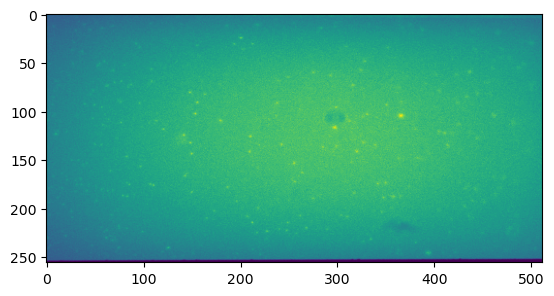

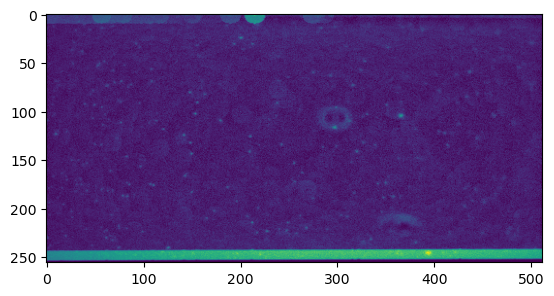

In [58]:
fig, ax = plt.subplots()
ax.imshow(red1)
plt.show()
fig, ax = plt.subplots()
red2 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
ax.imshow(red2)
plt.show()

In [30]:
traces_red =  np.zeros([n_traces,n_frames])
traces_green = np.zeros([n_traces,n_frames])
red1 = img_smFRET[:,256:,:]
green1 = img_smFRET[:,:256,:]
            
print('Starting rolling ball')
red1 = stack_subtract_background(red1,n_frames)
print('Finished RB red')
green1 = stack_subtract_background(green1,n_frames)
print('Finished RB green')

634


In [7]:
# from scipy.io import savemat
# Save traces and sequences
frame_rate = 5
mdict = {
    "time": np.divide(range(n_frames),frame_rate),
    "Cy3": traces_green,
    "Cy5": traces_red,
#                 "Seq": seq_matched
}

savemat(path_smFRET_file.split('.')[0] + "_traces.mat", mdict)

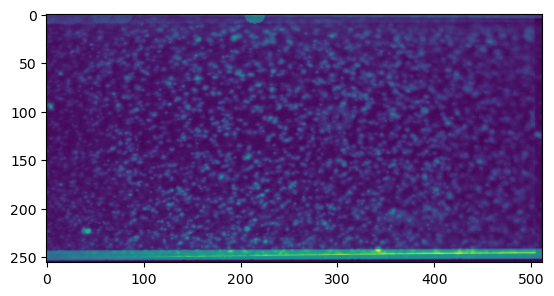

In [15]:
path_smFRET_file = 'D:/Experiments/MUSCLE DONUTS/220719/Cas9_CCR5/op\Pos118.tiff'
rb_rad = 10
img_smFRET = io.imread(path_smFRET_file)
# Averaging the first 10 frames to select peaks
img_t = np.mean(img_smFRET[0:10,::], axis = 0)
img_t = img_t.astype("ushort")
rb_rad = 10
#print(img1[10:20,10:20])
#img = np.zeros([20,20])
#img[10,5] = 1000
red = img_t[256:,:]
green = img_t[:256,:]
red = red - rolling_ball(red, radius=rb_rad)
green = green - rolling_ball(green, radius=rb_rad)
green = transform.warp(green,tr_R2G, preserve_range = True)
combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
fig, ax = plt.subplots()
ax.imshow(combined)